In [1]:
# ---------------------------------------------------------------------------- #
# An implementation of https://arxiv.org/pdf/1512.03385.pdf                    #
# See section 4.2 for the model architecture on CIFAR-10                       #
# Some part of the code was referenced from below                              #
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# ---------------------------------------------------------------------------- #
!pip install ipython-autotime
%load_ext autotime
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=6b4844a6d984eb2114a696e6246c0b9b383b334e8636523266799cc48b191cad
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [2]:
# Hyper-parameters
num_epochs = 80
learning_rate = 0.01

time: 1.05 ms


In [3]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomRotation((0,5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomVerticalFlip(p=0.5),
    #transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    #transforms.RandomRotation(degrees=[-10,10], resample=False, expand=False, center=None, fill=0),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

time: 4.94 ms


In [0]:
#transform_train = transforms.Compose([
#    transforms.RandomCrop(32, padding=4),
#    transforms.RandomHorizontalFlip(),
#    transforms.ToTensor(),
#    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#])

#transform_test = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#])


In [4]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

Extracting ../../data/cifar-10-python.tar.gz to ../../data/
time: 6.68 s


In [5]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=32, 
                                          shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



time: 3.36 ms


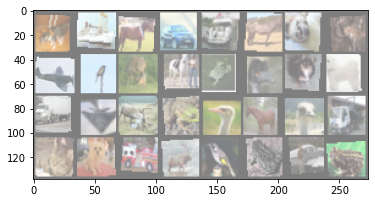

  cat  ship horse   car
time: 337 ms


In [6]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

time: 1.5 ms


In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        dropout=0.25
        dropout = 0 if dropout is None else dropout
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(dropout)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.dropout(out)
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out

time: 41.1 ms


In [9]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        dropout=0.30
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.dropout = nn.Dropout(dropout)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.dropout(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

time: 17.1 ms


In [10]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        self.linear = nn.Linear(128*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

time: 23.2 ms


In [11]:
#RESNET-18
#model = ResNet(BasicBlock, [2,2,2,2]).to(device)
#RESNET-34
model = ResNet(BasicBlock, [3,4,6,3]).to(device)
#RESNET-50
#model = ResNet(Bottleneck, [3,4,6,3]).to(device)
#RESNET-101
#model = ResNet(Bottleneck, [3,4,23,3]).to(device)
#RESNET-152
#model = ResNet(Bottleneck, [3,8,36,3]).to(device)


time: 8.87 s


In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

time: 3.44 ms


In [13]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    correct = 0
    total = 0
    for i,(images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #if (i+1) % 100 == 0:
          
    print ("Epoch [{}/{}], Train Loss: {:.4f} Train Accuracy: {} %"
                   .format(epoch+1, num_epochs,  loss.item(),round((100 * correct / total),2)))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/80], Train Loss: 1.8330 Train Accuracy: 35.16 %
Epoch [2/80], Train Loss: 1.1021 Train Accuracy: 51.53 %
Epoch [3/80], Train Loss: 0.9896 Train Accuracy: 59.76 %
Epoch [4/80], Train Loss: 1.0666 Train Accuracy: 64.72 %
Epoch [5/80], Train Loss: 1.0883 Train Accuracy: 69.03 %
Epoch [6/80], Train Loss: 0.5419 Train Accuracy: 71.55 %
Epoch [7/80], Train Loss: 1.0181 Train Accuracy: 73.58 %
Epoch [8/80], Train Loss: 0.6510 Train Accuracy: 75.18 %
Epoch [9/80], Train Loss: 0.6330 Train Accuracy: 76.51 %
Epoch [10/80], Train Loss: 0.7059 Train Accuracy: 77.37 %
Epoch [11/80], Train Loss: 0.2756 Train Accuracy: 78.19 %
Epoch [12/80], Train Loss: 0.4463 Train Accuracy: 78.84 %
Epoch [13/80], Train Loss: 0.4341 Train Accuracy: 79.4 %
Epoch [14/80], Train Loss: 0.5924 Train Accuracy: 80.1 %
Epoch [15/80], Train Loss: 0.4303 Train Accuracy: 80.48 %
Epoch [16/80], Train Loss: 0.6954 Train Accuracy: 80.72 %
Epoch [17/80], Train Loss: 0.7829 Train Accuracy: 81.13 %
Epoch [18/80], Train Loss

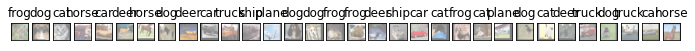

time: 861 ms


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(train_loader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

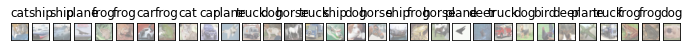

time: 864 ms


In [15]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [16]:
images = images.to(device)
labels = labels.to(device)
outputs = model(images)

time: 15.1 ms


In [17]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)

time: 7.53 ms


In [18]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

cat - 0.9983
ship - 0.9997
ship - 0.9984
plane - 0.7009
frog - 0.9997
frog - 0.9996
car - 0.9971
frog - 0.9544
cat - 0.9986
car - 0.9958
plane - 0.9978
truck - 0.9999
dog - 0.9885
horse - 0.9996
truck - 1.0000
ship - 0.9552
dog - 0.9998
horse - 0.9929
ship - 0.9999
frog - 1.0000
horse - 0.9949
plane - 0.7603
deer - 0.9768
truck - 0.9998
deer - 0.7390
bird - 0.9885
deer - 0.7645
plane - 0.9996
truck - 0.9894
frog - 0.9948
frog - 0.9693
dog - 0.9991
time: 15.9 ms


In [19]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 88.59%
time: 3.36 s


In [20]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 88.8
car        - 95.9
bird       - 82.6
cat        - 76.0
deer       - 87.5
dog        - 84.4
frog       - 90.1
horse      - 91.9
ship       - 95.0
truck      - 93.7
time: 4.78 ms


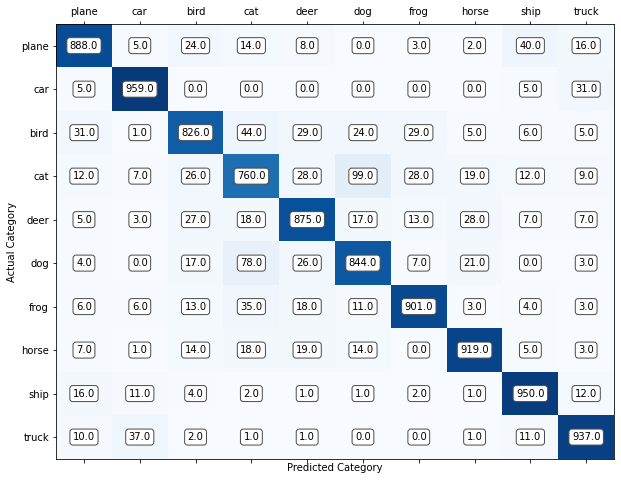

time: 441 ms


In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'),)
for (i, j), z in np.ndenumerate(confusion_matrix):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()



In [22]:
# Save the model checkpoint
torch.save(model.state_dict(), 'resnet.ckpt')

time: 43.6 ms


In [23]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

1334618

time: 4.96 ms
